<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/notebooks/measuring_dataset_quality_with_probability_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset setup
The data came from:
https://www.kaggle.com/andrewmvd/car-plate-detection. This dataset contains 433 images with bounding box annotations of the car license plates within the image. Due to the size of the data files, it is best to copy them to a google drive and mount it.



## Manual setup
Mounting the google drive and initializing Weights and Biases require manual *interactions*

### Mount the google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Weigts and Biases

In [2]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 14.3MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 174kB 47.6MB/s 
     |████████████████████████████████| 133kB 42.0MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Prepare the data

Import libraries and set some global variables

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

IMAGE_SIZE = 224
DATA_ROOT = "./drive/MyDrive/data/Kaggle_license_plates"

# import os
# for dirname, _, filenames in os.walk(DATA_ROOT):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

We create the variable X containing all the images of cars by resizing them.



In [4]:
img_dir = DATA_ROOT + "/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X_raw=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resize_annotation for that. 

In [5]:
from lxml import etree
def resize_annotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmin), int(ymin), int(xmax), int(ymax)]
        

In [6]:
label_dir = DATA_ROOT + "/annotations"
text_files = [DATA_ROOT + '/annotations/'+f for f in sorted(os.listdir(label_dir))]

y_raw=[]
for f in text_files:
    # print(f)
    y_raw.append(resize_annotation(f))

### Change annotations to YOLO v5 format
The rectangle positions are turned into YOLO v5 format for two reasons.

1. To make integrating other datasets easy
2. Model predictions can be handled better if they are in YOLO v5 format. Rectangle points tend to give more negative prediction results which are invalid.

YOLO v5 format is:

class-id x-center y-center width height

https://github.com/ultralytics/yolov5/issues/12

In [7]:
# change to yolo v5 format
# https://github.com/ultralytics/yolov5/issues/12
# [x_top_left, y_top_left, x_bottom_right, y_bottom_right] to
# [x_center, y_center, width, height]
def to_yolov5(y):
  width = y[2] - y[0]
  height = y[3] - y[1]

  if width < 0 or height < 0:
    print("ERROR: negative width or height ", width, height, y)
    raise AssertionError("Negative width or height")
  return int(y[0] + (width/2)), int(y[1] + (height/2)), width, height

y_yolov5 = np.array([to_yolov5(y) for y in y_raw])
y_yolov5[0]

array([144, 124,  86,  40])

In [8]:
# NB: the values are scaled down to 0..1
def to_rect(y):
  width = np.clip(y[2], 0, IMAGE_SIZE)
  height = np.clip(y[3], 0, IMAGE_SIZE)

  if width < 0 or height < 0:
    print("ERROR: negative width or height ", width, height, y)
    raise AssertionError("Negative width or height")

  return int(y[0] - width/2), int(y[1] - height/2), int(y[0] + width/2), int(y[1] + height/2)

In [9]:
def print_file(text_file):
  with open(text_file, "r") as file:
    for line in file:
      print(line)

We check X and y shape

In [10]:
print(np.array(X_raw).shape)
print(np.array(y_raw).shape)

(433, 224, 224, 3)
(433, 4)


A method to introduce noise to annotations.

In [88]:
def noise_annotation(y, scale, noise_type='normal'):
  def _normal(e):
    num = int(np.random.normal(loc=e, scale=scale, size=1))
    return np.clip(num, 0, IMAGE_SIZE)

  y_noise = []
  for y1 in y:
    if noise_type == 'uniform':
      x_center = int(np.random.uniform(y1[0] - scale, y1[0] + scale, 1))
      y_center = int(np.random.uniform(y1[1] - scale, y1[1] + scale, 1))
      width = int(np.random.uniform(y1[2] - scale, y1[2] + scale, 1))
      height = int(np.random.uniform(y1[3] - scale, y1[3] + scale, 1))

      y_noise.append(np.array([x_center, y_center, width, height]).reshape(-1))
    else:
      y_noise.append([_normal(y1[0]), _normal(y1[1]),
                      _normal(y1[2]), _normal(y1[3])])

  return np.array(y_noise)

# print("original: ", y_raw[0])
# y_noise = noise_annotation(y_raw, 5)
# print("with noise: ", y_noise[0])
# noise_annotation(np.array([[1, 2, 3, 4]]), 1)

original:  [101, 104, 187, 144]
with noise:  [103 106 192 143]


array([[2, 0, 4, 4]])

And we display the first eighteen image of the dataset : 

In [12]:
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # width = y[2] - y[0]
  # height = y[3] - y[1]
  # return patches.Rectangle((y[0], y[1]),
  #                           width, height,
  #                           edgecolor=color, fill=False)
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

### Transform & normalize data
We cluster the data first and then do partitioning the dataset into training, validation and test.

In [13]:
# from sklearn.model_selection import train_test_split

#Transforming in array
X = np.array(X_raw)
y = np.array(y_yolov5)

#Renormalisation
X = X / IMAGE_SIZE
y = y / IMAGE_SIZE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [14]:
def plot_images(X, y):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y) if len(y) < 50 else 50

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_patch_rectangle(y[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)
    plt.imshow(np.clip(image, 0, 1))

## Clustering

THe dataset is clustered into five sets and each cluster is partitioned into training, validatiion and test sets so that they have the same distributions in training, validation and test sets.

| Cluster | Train | Validation | Test | Total |
|---------|-------|------------|------|------|
| 0 | 111 | 13 |	31	| 155 |
| 1 | 53	| 6	| 15	| 74 |
| 2 | 41	| 5	| 12	| 58 |
| 3 | 57	| 7	| 17	| 81 |
| 4 | 46	| 6	| 13	| 65 |
| Total  | 308	| 37	| 88 |	433 |



---



### Run K Means clustering on data

The Elbow method found 11 to be optimal clusters, but given the small number of data, we can choose a smaller number of clusters for the experiments.

Ideally, we want to:

1. Ensure that we have the same distributions for train, validation and test datasets.
2. Pick uniformally across various dataset clusters.
3. Observe any discrepancies across clusters.
4. Find the minimum set of training sets for optimal performance.


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions

# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input, decode_predictions

#Calculate similar matrics
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim,np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim/norms/norms.T)

def get_feature_maps(input):
    # #Convert to VGG input format
    # NB: This messes up the existing data so skipping it
    #   similarity measures do not seem to be affected by this.
    # vgg_input = preprocess_input(input)

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights = "imagenet", include_top=False)

    #Get features
    # feature_maps = model.predict(vgg_input)
    feature_maps = model.predict(input)

    return feature_maps, model

    # #Calculate similar metrics
    # features_compress = features.reshape(len(y_test), 7*7*512)
    # sim = cosine_similarity(features_compress)

# model_vgg16, feature_maps = get_feature_maps(X)

### Cluster the whole dataset then partition
The optimal number of clusters depends on the dataset. For the kaggle dataset, five seems to be a good number as this will give us a balanced distribution for all clusters.

58892288/58889256 [==============================] - 1s 0us/step


<BarContainer object of 5 artists>

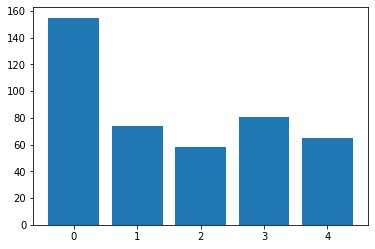

In [16]:
# 5 clusters seems to work well for this dataset
K = 5

fm_x, _ = get_feature_maps(X)
# use cosine distance to find similarities
fm_x_normalized = preprocessing.normalize(fm_x.reshape(len(fm_x), -1))

clusters_x = KMeans(n_clusters=K, random_state=0).fit(fm_x_normalized)
histo_x, bins = np.histogram(clusters_x.labels_, bins=range(K + 1))

# plt.hist(bins[:-1], bins, weights=histo_x, histtype='step', label='x')
plt.bar(bins[:-1], histo_x, align='center')

<BarContainer object of 5 artists>

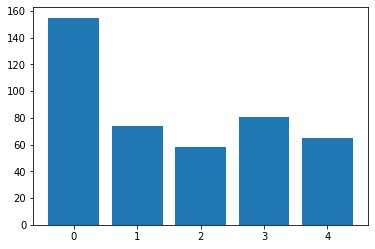

In [17]:
plt.bar(bins[:-1], histo_x, align='center')

In [18]:
bins, cluster_x_counts = np.unique(clusters_x.labels_, return_counts=True)

def to_clusters_dict(bins, data):
  cluster_dict = dict()
  for cluster_id in bins:
    cluster_dict[cluster_id] = np.where(data == cluster_id)[0]
  return cluster_dict

clusters_dict = to_clusters_dict(range(K), clusters_x.labels_)

### Partition the cluster into train, validation and test sets

In [19]:
from sklearn.model_selection import train_test_split

def partition_on_clusters(X, y, bins, clusters_dict, test_size=0.2, val_size=0.1):
  X_train_d = dict()
  y_train_d = dict()
  X_val_d = dict()
  y_val_d = dict()
  X_test_d = dict()
  y_test_d = dict()

  # for each cluster reserve test_size portion for test data
  for cluster_id in bins:
    clusters_ids = clusters_dict[cluster_id]
    Xt = X[clusters_ids]
    yt = y[clusters_ids]

    Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.2, shuffle=False)
    Xt_train, Xt_val, yt_train, yt_val = train_test_split(Xt_train, yt_train, test_size=0.1, shuffle=False)

    X_train_d[cluster_id] = Xt_train
    y_train_d[cluster_id] = yt_train

    X_val_d[cluster_id] = Xt_val
    y_val_d[cluster_id] = yt_val

    X_test_d[cluster_id] = Xt_test
    y_test_d[cluster_id] = yt_test

  return X_train_d, y_train_d, \
         X_val_d, y_val_d, \
         X_test_d, y_test_d

X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = \
          partition_on_clusters(X, y, bins, clusters_dict)


In [20]:
test_ids = clusters_dict[0] < len(clusters_dict[0])
test_ids

clusters_dict[0][test_ids]

array([  0,   1,  10,  13,  14,  15,  20,  24,  27,  34,  35,  41,  44,
        47,  49,  51,  52,  54,  55,  58,  61,  62,  63,  75,  76,  77,
        79,  81,  82,  83,  85,  87,  88,  89,  97, 100, 101, 104, 112,
       118, 119, 122, 123, 128, 131, 132, 135, 138, 139, 146])

In [21]:
# merge all clusters
def merge_clusters(clusters_d):
  merged = []
  for cluster_id, cluster in clusters_d.items():
    if cluster_id == 0:
      merged = cluster
    else:
      merged = np.vstack((merged, cluster))
  return merged

# merged = merge_clusters(y_train_d)

# Metrics
Define methods to measure model performance. Methods to calculate IoU (Intersection over Union) and mAP (mean average precision).

In [22]:
#GT Boxes
gt_boxes= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
#Pred Boxes
pred_boxes={"img_00285.png": {"boxes":
                             [[330, 463, 387, 505],
                              [356, 456, 391, 521],
                              [420, 433, 451, 498],
                              [468, 435, 520, 521]],
                              "scores": [0.0739, 0.0843, 0.091, 0.1008]}}

def create_gt_boxes(X_test):
  gt_boxes = dict()
  for id in range(len(X_test)):
    gt_boxes[str(id)] = [list(X_test[id].tolist())]
  return gt_boxes

def create_pred_boxes(y_preds, scores):
  pred_boxes = dict()
  for id in range(len(y_preds)):
    pred_boxes[str(id)] =  {
        "boxes": [y_preds[id].tolist()],
        "scores": list(scores[id])
    }
  return pred_boxes

In [23]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

## IOU

In [24]:
# https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
      # return 0.0
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",
                             x_topleft_p, x_bottomright_p, y_topleft_p, y_bottomright_gt)
      # return 0.0
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
      return 0.0

    if(y_bottomright_gt < y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
      return 0.0
    if(x_topleft_gt > x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
      return 0.0

    if(y_topleft_gt > y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
      return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [25]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [26]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [27]:
from copy import deepcopy
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        # print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
    
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
# Recalculate image results for this image
            # print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img,
                                      pred_boxes_pruned[img_id]['boxes'],
                                      iou_thr=0.5)
# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            # print(recalls,"Recall")
            # print(      recall_level,"Recall Level")
            # print(       args, "Args")
            # print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [28]:
# this method is borrowed from
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # print("xA:{} yA:{} xB:{} yB:{}".format(xA, yA, xB, yB))
    # print("xB - xA + 1:{} yB - yA + 1:{}".format(xB - xA + 1, yB - yA + 1))

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # print("interArea:{}".format(interArea))

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # print("boxAArea:{} boxBArea:{}".format(boxAArea, boxBArea))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

# This also works, but does not quite work in some cases
# https://medium.com/koderunners/intersection-over-union-516a3950269c
def bb_iou2(box1, box2):
    x1, y1, x12, y12 = box1
    x2, y2, x22, y22 = box2
    w1 = x1 - x12
    h1 = y1 - y12
    w2 = x2 - x22
    h2 = y2 - y22
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

## Calculate mAP

In [29]:
# averages out sample predictions (input data)x(samples)x(prediction points = 4)
# into (input data)x(averaged prediction points = 4)
def average_sample_preds(y_sample_preds):
  averages = []
  for y_pred in y_sample_preds:
    averages.append([np.mean(y_pred[:, i]) for i in range(y_pred.shape[1])])
  return np.array(averages)

def calculate_map(y_test_scaled, y_preds_scaled, threshold=0.5):
  # y_test_scaled = y_test*IMAGE_SIZE
  # y_preds_scaled = y_preds*IMAGE_SIZE
  scores = [[calc_iou(y_test_scaled[id], y_preds_scaled[id])] for id in range(len(y_test_scaled))]

  gt_boxes = create_gt_boxes(y_test_scaled)
  preds_boxes = create_pred_boxes(y_preds_scaled, scores)

  map = get_avg_precision_at_iou(gt_boxes=gt_boxes, pred_bb=preds_boxes)
  # print("mAP:{:.2}".format(map['avg_prec']))
  return map

# Models

### Create CNN Model
Vanilla CNN to establish the baseline. It was built on top of VGG16.

In [39]:
# Create the model
def create_cnn_model():
  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(4, activation="sigmoid"))

  model.layers[-6].trainable = False
  model.summary()

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  return model

### Create Probability Model
The probability model is a 'hybrid' model where only the last layer is probabilistic. A full probabilistic model is supposed to have all layers output probabilistic distributions but it does not converge successfully after many tries and thus the hybrid model. A further research is needed to make it a fully probabilistic.

In [40]:
kl_divergence_fn = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(y_train.shape[0], dtype=tf.float32)

# Create the model
def create_prob_model():
  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(tfp.layers.DenseFlipout(4, activation="sigmoid", kernel_divergence_fn=kl_divergence_fn))

  model.layers[-6].trainable = False
  model.summary()

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  return model

In [51]:
create_prob_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


# Experiment Setup

In [41]:
def scale_up(rect):
  rect = rect*IMAGE_SIZE
  return int(rect[0]), int(rect[1]), int(rect[2]), int(rect[3])

def plot_predictions(X, y_gt, y_preds):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y_gt) if len(y_gt) < 50 else 50

  y_preds_avg = average_sample_preds(y_preds)
  stds = np.std(y_preds, axis=1)
  mean_stds = np.mean(stds, axis=1)

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_patch_rectangle(y_gt[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)

    # for each test image, there could be multiple predictions
    for y_pred in y_preds[i]:
      rect_pred = create_patch_rectangle(y_pred*IMAGE_SIZE, (255/255, 0, 0))
      axis.add_patch(rect_pred)

    iou = bb_iou(to_rect(y_preds_avg[i]*IMAGE_SIZE), to_rect(y_gt[i]*IMAGE_SIZE))
    plt.title("IOU: {:0.2f} std: {:0.2f}".format(iou, mean_stds[i]))
    # plt.title("mean std: {:0.2f}".format(mean_stds[sample_ids[i]]))
    plt.imshow(np.clip(image, 0, 1))

In [42]:
# def plot_predictions_old(X_test, y_test, y_pred):
#   fig = plt.figure(figsize=(20,40))

#   end_id = len(y_test) if len(y_test) < 50 else 50
#   for i in range(0, end_id):
#     axis = fig.add_subplot(10, 5, i+1)
#     plt.subplot(10,5,i+1)
#     plt.axis('off')

#     image = X_test[i]

#     # for j in range(0, len(y_preds[i])):
#     #   # rect_pred = create_patch_rectangle(y_preds[i][j]*IMAGE_SIZE, (255/255, 0, 0))
#     #   rect_pred = create_patch_rectangle(y_preds[y_preds[i]][j]*IMAGE_SIZE, (255/255, 0, 0))
#     #   axis.add_patch(rect_pred)

#     y_pred1 = y_pred[i]*IMAGE_SIZE
#     y_pred1 = int(y_pred1[0]), int(y_pred1[1]), int(y_pred1[2]), int(y_pred1[3])

#     y_gt1 = y_test[i]*IMAGE_SIZE
#     y_gt1 = int(y_gt1[0]), int(y_gt1[1]), int(y_gt1[2]), int(y_gt1[3])

#     rect_ori = create_patch_rectangle(y_gt1, (0, 255/255, 0))
#     rect_pred = create_patch_rectangle(y_pred1, (255/255, 0, 0))
#     axis.add_patch(rect_ori)
#     axis.add_patch(rect_pred)

#     iou = bb_iou(y_pred1, y_gt1)
#     iou2 = bb_iou2(y_pred1, y_gt1)

#     plt.title("IOU: {:0.2f} IOU2:{:0.2f}".format(iou, iou2))
#     plt.imshow(image)

### Fix predictions

For really bad predictions, do some minimal fix for display and calculation purposes

In [43]:
# def fix_predictions(y_preds):
#   errors = dict()

#   for id in range(len(y_preds)):
#     for sample_id in range(len(y_preds[id])):
#       x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
#       if x_topleft_p > x_bottomright_p:
#         # y_preds[id][sample_id][0] = x_bottomright_p
#         # y_preds[id][sample_id][2] = x_topleft_p
#         y_preds[id][sample_id][2] = x_topleft_p + .01/IMAGE_SIZE
#         errors[id] = 1
#         # x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
#         # print("Fixed xbr", x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p)
#       if y_topleft_p > y_bottomright_p:
#         # y_preds[id][sample_id][1] = y_bottomright_p
#         # y_preds[id][sample_id][3] = y_topleft_p
#         y_preds[id][sample_id][3] = y_topleft_p + .01/IMAGE_SIZE
#         # errors += 1
#         errors[id] = 1
#         # x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
#         # print("Fixed ybr", x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p)
#   print("Fixed predictions: {}/{} {}".format(len(errors), len(y_preds), errors))
#   return y_preds

## Run experiment

In [330]:
def train(model, X_train, y_train,
                 X_val, y_val,
                 X_test, y_test,
                 epochs, batch_size,
                 is_plot_predictions=False):
  train_history = model.fit(x=X_train, y=y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1,
                            callbacks=[wandb.keras.WandbCallback(data_type="image",
                            save_model=False)])
  # Test
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Score : %.2f%%" % (scores[1]*100))

  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=int(100))

  print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

  y_preds = sample_predictions(model, X_test, iterations=1)
  # y_preds = model.predict(X_test)

  # # TODO:
  # # Hack to fix erroneous predictions
  # y_preds = fix_predictions(y_preds)
  if is_plot_predictions:
    plot_predictions(X_test, y_test, y_preds)

  averaged_predictions = average_sample_preds(y_preds)
  y_test = np.array([to_rect(y*IMAGE_SIZE) for y in y_test])
  rectified_predictions = np.array([to_rect(y*IMAGE_SIZE) for y in averaged_predictions])

  # print(rectified_predictions)
  m_ap = calculate_map(y_test*IMAGE_SIZE, rectified_predictions*IMAGE_SIZE)
  return model, y_preds, m_ap

## Sample predictions

In [45]:
def sample_predictions(model, samples, iterations=10):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(samples).numpy())

    predicted = np.array(predicted)
    # predicted = np.concatenate(predicted, axis=1)

    # predicted = np.array([model_prob.predict(np.expand_dims(X_test[1], [0])) for i in range(iterations)])
    # predicted = np.concatenate(predicted, axis=1)
    reshaped = np.array([predicted[:, column] for column in range(0, predicted.shape[1])])

    return reshaped
    
def calculate_prediction_std(y_preds):
  mean = np.mean(y_preds)

  mean_stds = []
  for cluster_id in range(len(cluster_ids)):
    predicted = sample_predictions(model, X[cluster_ids[cluster_id]], iterations=50)

    stds = np.std(predicted, axis=1)
    mean_std = np.mean(stds, axis=1)
    # print(mean_std)
    print("{}: mean std: {:0.2f}".format(cluster_id, np.mean(mean_std)))
    mean_stds.append(mean_std)
  
  return mean_stds

## Run experiment on cluster

In [331]:
def train_on_cluster(model, cluster_id):
  X_ttrain = X_train[cluster_ids_train[cluster_id]]
  y_ttrain = y_train[cluster_ids_train[cluster_id]]

  X_tval = X_val[cluster_ids_val[cluster_id]]
  y_tval = y_val[cluster_ids_val[cluster_id]]

  X_ttest = X_test[cluster_ids_test[cluster_id]]
  y_ttest = y_test[cluster_ids_test[cluster_id]]

  batch_size = len(y_ttest)
  model, y_pred, map = train(model,
                             X_ttrain, y_ttrain,
                             X_tval, y_tval,
                             X_ttest, y_ttest, 50, batch_size)
  return model, y_pred, map


# model_prob_clst = create_prob_model()
# model_clst, y_pred_clst, map_clst = run_experiment_on_cluster(model_prob_clst, 2)

## Prepare train, validation, and test data

In [47]:
X_train = merge_clusters(X_train_d)
y_train = merge_clusters(y_train_d)

X_val = merge_clusters(X_val_d)
y_val = merge_clusters(y_val_d)

X_test = merge_clusters(X_test_d)
y_test = merge_clusters(y_test_d)


# Train
Train with different datasets.

## Train on clean data with regular CNN
Everything is clean. y_train and y_val are all clean labels.

In [ ]:
wandb.init(project="clustered-data-regular-cnn",
           config={
               "batch_size": 32,
               "learning_rate": 0.01,
               "dataset": "clustered-data-regular-cnn",
           })

model_clean_train = create_model()
model_clean_train, y_pred_clean_train, map = train(model_clean_train,
                                                   X_train, y_train,
                                                   X_val, y_val,
                                                   X_test, y_test,
                                                   50, 32)

## Train with probability
This is the baseline probabilistic model to compare with other models. It should have the best performance.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
____________________________________

wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/100
10/10 [==============================] - 1s 57ms/step - loss: 2.1344 - accuracy: 0.6132 - val_loss: 2.1109 - val_accuracy: 0.5946


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/100
10/10 [==============================] - 1s 61ms/step - loss: 2.1068 - accuracy: 0.6296 - val_loss: 2.0959 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/100
10/10 [==============================] - 1s 58ms/step - loss: 2.0929 - accuracy: 0.7197 - val_loss: 2.0893 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/100
10/10 [==============================] - 1s 58ms/step - loss: 2.0807 - accuracy: 0.7234 - val_loss: 2.0781 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 2.0701 - accuracy: 0.7836 - val_loss: 2.0673 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/100
10/10 [==============================] - 1s 59ms/step - loss: 2.0618 - accuracy: 0.8072 - val_loss: 2.0597 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/100
10/10 [==============================] - 1s 60ms/step - loss: 2.0522 - accuracy: 0.7947 - val_loss: 2.0498 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/100
10/10 [==============================] - 1s 57ms/step - loss: 2.0441 - accuracy: 0.8251 - val_loss: 2.0423 - val_accuracy: 0.6216


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/100
10/10 [==============================] - 1s 58ms/step - loss: 2.0351 - accuracy: 0.8149 - val_loss: 2.0344 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/100
10/10 [==============================] - 1s 58ms/step - loss: 2.0275 - accuracy: 0.7670 - val_loss: 2.0261 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/100
10/10 [==============================] - 1s 59ms/step - loss: 2.0175 - accuracy: 0.8715 - val_loss: 2.0179 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/100
10/10 [==============================] - 1s 57ms/step - loss: 2.0101 - accuracy: 0.8123 - val_loss: 2.0098 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/100
10/10 [==============================] - 1s 56ms/step - loss: 2.0008 - accuracy: 0.8178 - val_loss: 2.0015 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9928 - accuracy: 0.8167 - val_loss: 1.9931 - val_accuracy: 0.6216


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9850 - accuracy: 0.8203 - val_loss: 1.9846 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9770 - accuracy: 0.8004 - val_loss: 1.9768 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/100
10/10 [==============================] - 1s 57ms/step - loss: 1.9685 - accuracy: 0.8581 - val_loss: 1.9681 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/100
10/10 [==============================] - 1s 57ms/step - loss: 1.9601 - accuracy: 0.8771 - val_loss: 1.9614 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/100
10/10 [==============================] - 1s 60ms/step - loss: 1.9524 - accuracy: 0.8161 - val_loss: 1.9527 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 21/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9447 - accuracy: 0.8392 - val_loss: 1.9461 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 22/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9361 - accuracy: 0.8145 - val_loss: 1.9364 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 23/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9285 - accuracy: 0.8126 - val_loss: 1.9302 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 24/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9201 - accuracy: 0.7862 - val_loss: 1.9207 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 25/100
10/10 [==============================] - 1s 59ms/step - loss: 1.9128 - accuracy: 0.8532 - val_loss: 1.9128 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 26/100
10/10 [==============================] - 1s 56ms/step - loss: 1.9046 - accuracy: 0.8392 - val_loss: 1.9041 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 27/100
10/10 [==============================] - 1s 60ms/step - loss: 1.8963 - accuracy: 0.8125 - val_loss: 1.8989 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 28/100
10/10 [==============================] - 1s 59ms/step - loss: 1.8882 - accuracy: 0.8540 - val_loss: 1.8867 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 29/100
10/10 [==============================] - 1s 64ms/step - loss: 1.8801 - accuracy: 0.8974 - val_loss: 1.8811 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 30/100
10/10 [==============================] - 1s 61ms/step - loss: 1.8724 - accuracy: 0.8274 - val_loss: 1.8719 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 31/100
10/10 [==============================] - 1s 59ms/step - loss: 1.8647 - accuracy: 0.8515 - val_loss: 1.8623 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 32/100
10/10 [==============================] - 1s 59ms/step - loss: 1.8569 - accuracy: 0.7794 - val_loss: 1.8555 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 33/100
10/10 [==============================] - 1s 58ms/step - loss: 1.8478 - accuracy: 0.8665 - val_loss: 1.8511 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 34/100
10/10 [==============================] - 1s 62ms/step - loss: 1.8406 - accuracy: 0.8368 - val_loss: 1.8406 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 35/100
10/10 [==============================] - 1s 61ms/step - loss: 1.8320 - accuracy: 0.8303 - val_loss: 1.8318 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 36/100
10/10 [==============================] - 1s 59ms/step - loss: 1.8239 - accuracy: 0.8402 - val_loss: 1.8247 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 37/100
10/10 [==============================] - 1s 60ms/step - loss: 1.8161 - accuracy: 0.8306 - val_loss: 1.8162 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 38/100
10/10 [==============================] - 1s 57ms/step - loss: 1.8088 - accuracy: 0.8278 - val_loss: 1.8097 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 39/100
10/10 [==============================] - 1s 59ms/step - loss: 1.8008 - accuracy: 0.8932 - val_loss: 1.8008 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 40/100
10/10 [==============================] - 1s 59ms/step - loss: 1.7928 - accuracy: 0.8547 - val_loss: 1.7936 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 41/100
10/10 [==============================] - 1s 57ms/step - loss: 1.7851 - accuracy: 0.8708 - val_loss: 1.7846 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 42/100
10/10 [==============================] - 1s 59ms/step - loss: 1.7772 - accuracy: 0.8034 - val_loss: 1.7770 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 43/100
10/10 [==============================] - 1s 61ms/step - loss: 1.7692 - accuracy: 0.8222 - val_loss: 1.7713 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 44/100
10/10 [==============================] - 1s 58ms/step - loss: 1.7611 - accuracy: 0.8417 - val_loss: 1.7623 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 45/100
10/10 [==============================] - 1s 58ms/step - loss: 1.7530 - accuracy: 0.8489 - val_loss: 1.7548 - val_accuracy: 0.8378


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 46/100
10/10 [==============================] - 1s 57ms/step - loss: 1.7457 - accuracy: 0.8505 - val_loss: 1.7460 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 47/100
10/10 [==============================] - 1s 62ms/step - loss: 1.7374 - accuracy: 0.8592 - val_loss: 1.7380 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 48/100
10/10 [==============================] - 1s 57ms/step - loss: 1.7299 - accuracy: 0.7721 - val_loss: 1.7313 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 49/100
10/10 [==============================] - 1s 58ms/step - loss: 1.7228 - accuracy: 0.7872 - val_loss: 1.7225 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 50/100
10/10 [==============================] - 1s 58ms/step - loss: 1.7142 - accuracy: 0.8699 - val_loss: 1.7148 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 51/100
10/10 [==============================] - 1s 59ms/step - loss: 1.7069 - accuracy: 0.7605 - val_loss: 1.7095 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 52/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6981 - accuracy: 0.8039 - val_loss: 1.6982 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 53/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6912 - accuracy: 0.7960 - val_loss: 1.6904 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 54/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6830 - accuracy: 0.8345 - val_loss: 1.6837 - val_accuracy: 0.5946


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 55/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6755 - accuracy: 0.8183 - val_loss: 1.6771 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 56/100
10/10 [==============================] - 1s 58ms/step - loss: 1.6680 - accuracy: 0.8554 - val_loss: 1.6668 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 57/100
10/10 [==============================] - 1s 60ms/step - loss: 1.6593 - accuracy: 0.8339 - val_loss: 1.6603 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 58/100
10/10 [==============================] - 1s 58ms/step - loss: 1.6520 - accuracy: 0.8095 - val_loss: 1.6499 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 59/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6445 - accuracy: 0.7964 - val_loss: 1.6427 - val_accuracy: 0.5946


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 60/100
10/10 [==============================] - 1s 57ms/step - loss: 1.6360 - accuracy: 0.8222 - val_loss: 1.6369 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 61/100
10/10 [==============================] - 1s 58ms/step - loss: 1.6286 - accuracy: 0.8465 - val_loss: 1.6287 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 62/100
10/10 [==============================] - 1s 58ms/step - loss: 1.6209 - accuracy: 0.8052 - val_loss: 1.6210 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 63/100
10/10 [==============================] - 1s 61ms/step - loss: 1.6133 - accuracy: 0.7680 - val_loss: 1.6115 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 64/100
10/10 [==============================] - 1s 59ms/step - loss: 1.6059 - accuracy: 0.8205 - val_loss: 1.6048 - val_accuracy: 0.6216


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 65/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5977 - accuracy: 0.7994 - val_loss: 1.5975 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 66/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5904 - accuracy: 0.8184 - val_loss: 1.5897 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 67/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5830 - accuracy: 0.7814 - val_loss: 1.5833 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 68/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5743 - accuracy: 0.8150 - val_loss: 1.5749 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 69/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5667 - accuracy: 0.8059 - val_loss: 1.5685 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 70/100
10/10 [==============================] - 1s 61ms/step - loss: 1.5591 - accuracy: 0.8555 - val_loss: 1.5594 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 71/100
10/10 [==============================] - 1s 59ms/step - loss: 1.5518 - accuracy: 0.8201 - val_loss: 1.5526 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 72/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5441 - accuracy: 0.7746 - val_loss: 1.5420 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 73/100
10/10 [==============================] - 1s 58ms/step - loss: 1.5366 - accuracy: 0.7986 - val_loss: 1.5373 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 74/100
10/10 [==============================] - 1s 62ms/step - loss: 1.5285 - accuracy: 0.8456 - val_loss: 1.5295 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 75/100
10/10 [==============================] - 1s 56ms/step - loss: 1.5205 - accuracy: 0.8115 - val_loss: 1.5202 - val_accuracy: 0.6486


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 76/100
10/10 [==============================] - 1s 60ms/step - loss: 1.5125 - accuracy: 0.8004 - val_loss: 1.5132 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 77/100
10/10 [==============================] - 1s 58ms/step - loss: 1.5049 - accuracy: 0.8354 - val_loss: 1.5062 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 78/100
10/10 [==============================] - 1s 58ms/step - loss: 1.4979 - accuracy: 0.8069 - val_loss: 1.5023 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 79/100
10/10 [==============================] - 1s 60ms/step - loss: 1.4908 - accuracy: 0.7969 - val_loss: 1.4892 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 80/100
10/10 [==============================] - 1s 60ms/step - loss: 1.4831 - accuracy: 0.8123 - val_loss: 1.4806 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 81/100
10/10 [==============================] - 1s 62ms/step - loss: 1.4759 - accuracy: 0.8359 - val_loss: 1.4758 - val_accuracy: 0.6757


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 82/100
10/10 [==============================] - 1s 62ms/step - loss: 1.4676 - accuracy: 0.8142 - val_loss: 1.4670 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 83/100
10/10 [==============================] - 1s 58ms/step - loss: 1.4607 - accuracy: 0.7949 - val_loss: 1.4596 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 84/100
10/10 [==============================] - 1s 58ms/step - loss: 1.4524 - accuracy: 0.8237 - val_loss: 1.4536 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 85/100
10/10 [==============================] - 1s 60ms/step - loss: 1.4461 - accuracy: 0.7851 - val_loss: 1.4464 - val_accuracy: 0.5676


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 86/100
10/10 [==============================] - 1s 57ms/step - loss: 1.4369 - accuracy: 0.8224 - val_loss: 1.4354 - val_accuracy: 0.8378


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 87/100
10/10 [==============================] - 1s 59ms/step - loss: 1.4303 - accuracy: 0.8335 - val_loss: 1.4286 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 88/100
10/10 [==============================] - 1s 60ms/step - loss: 1.4224 - accuracy: 0.8383 - val_loss: 1.4238 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 89/100
10/10 [==============================] - 1s 57ms/step - loss: 1.4146 - accuracy: 0.7667 - val_loss: 1.4152 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 90/100
10/10 [==============================] - 1s 60ms/step - loss: 1.4075 - accuracy: 0.8052 - val_loss: 1.4051 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 91/100
10/10 [==============================] - 1s 60ms/step - loss: 1.3996 - accuracy: 0.8186 - val_loss: 1.3993 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 92/100
10/10 [==============================] - 1s 61ms/step - loss: 1.3917 - accuracy: 0.8160 - val_loss: 1.3930 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 93/100
10/10 [==============================] - 1s 61ms/step - loss: 1.3847 - accuracy: 0.7839 - val_loss: 1.3859 - val_accuracy: 0.5946


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 94/100
10/10 [==============================] - 1s 60ms/step - loss: 1.3775 - accuracy: 0.8185 - val_loss: 1.3767 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 95/100
10/10 [==============================] - 1s 59ms/step - loss: 1.3691 - accuracy: 0.7648 - val_loss: 1.3719 - val_accuracy: 0.7297


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 96/100
10/10 [==============================] - 1s 59ms/step - loss: 1.3616 - accuracy: 0.7943 - val_loss: 1.3624 - val_accuracy: 0.6216


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 97/100
10/10 [==============================] - 1s 59ms/step - loss: 1.3542 - accuracy: 0.8203 - val_loss: 1.3522 - val_accuracy: 0.7568


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 98/100
10/10 [==============================] - 1s 62ms/step - loss: 1.3475 - accuracy: 0.7601 - val_loss: 1.3476 - val_accuracy: 0.7838


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 99/100
10/10 [==============================] - 1s 60ms/step - loss: 1.3401 - accuracy: 0.7862 - val_loss: 1.3366 - val_accuracy: 0.8108


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 100/100
10/10 [==============================] - 1s 57ms/step - loss: 1.3333 - accuracy: 0.7295 - val_loss: 1.3344 - val_accuracy: 0.7027


wandb: WARNING No validation_data set, pass a generator to the callback.


Score : 78.41%
100/100 [==============================] - 1s 5ms/step - loss: 1.3310 - accuracy: 0.6818
Test results 
 Loss: 1.3309940099716187 
 Accuracy 0.6818181872367859


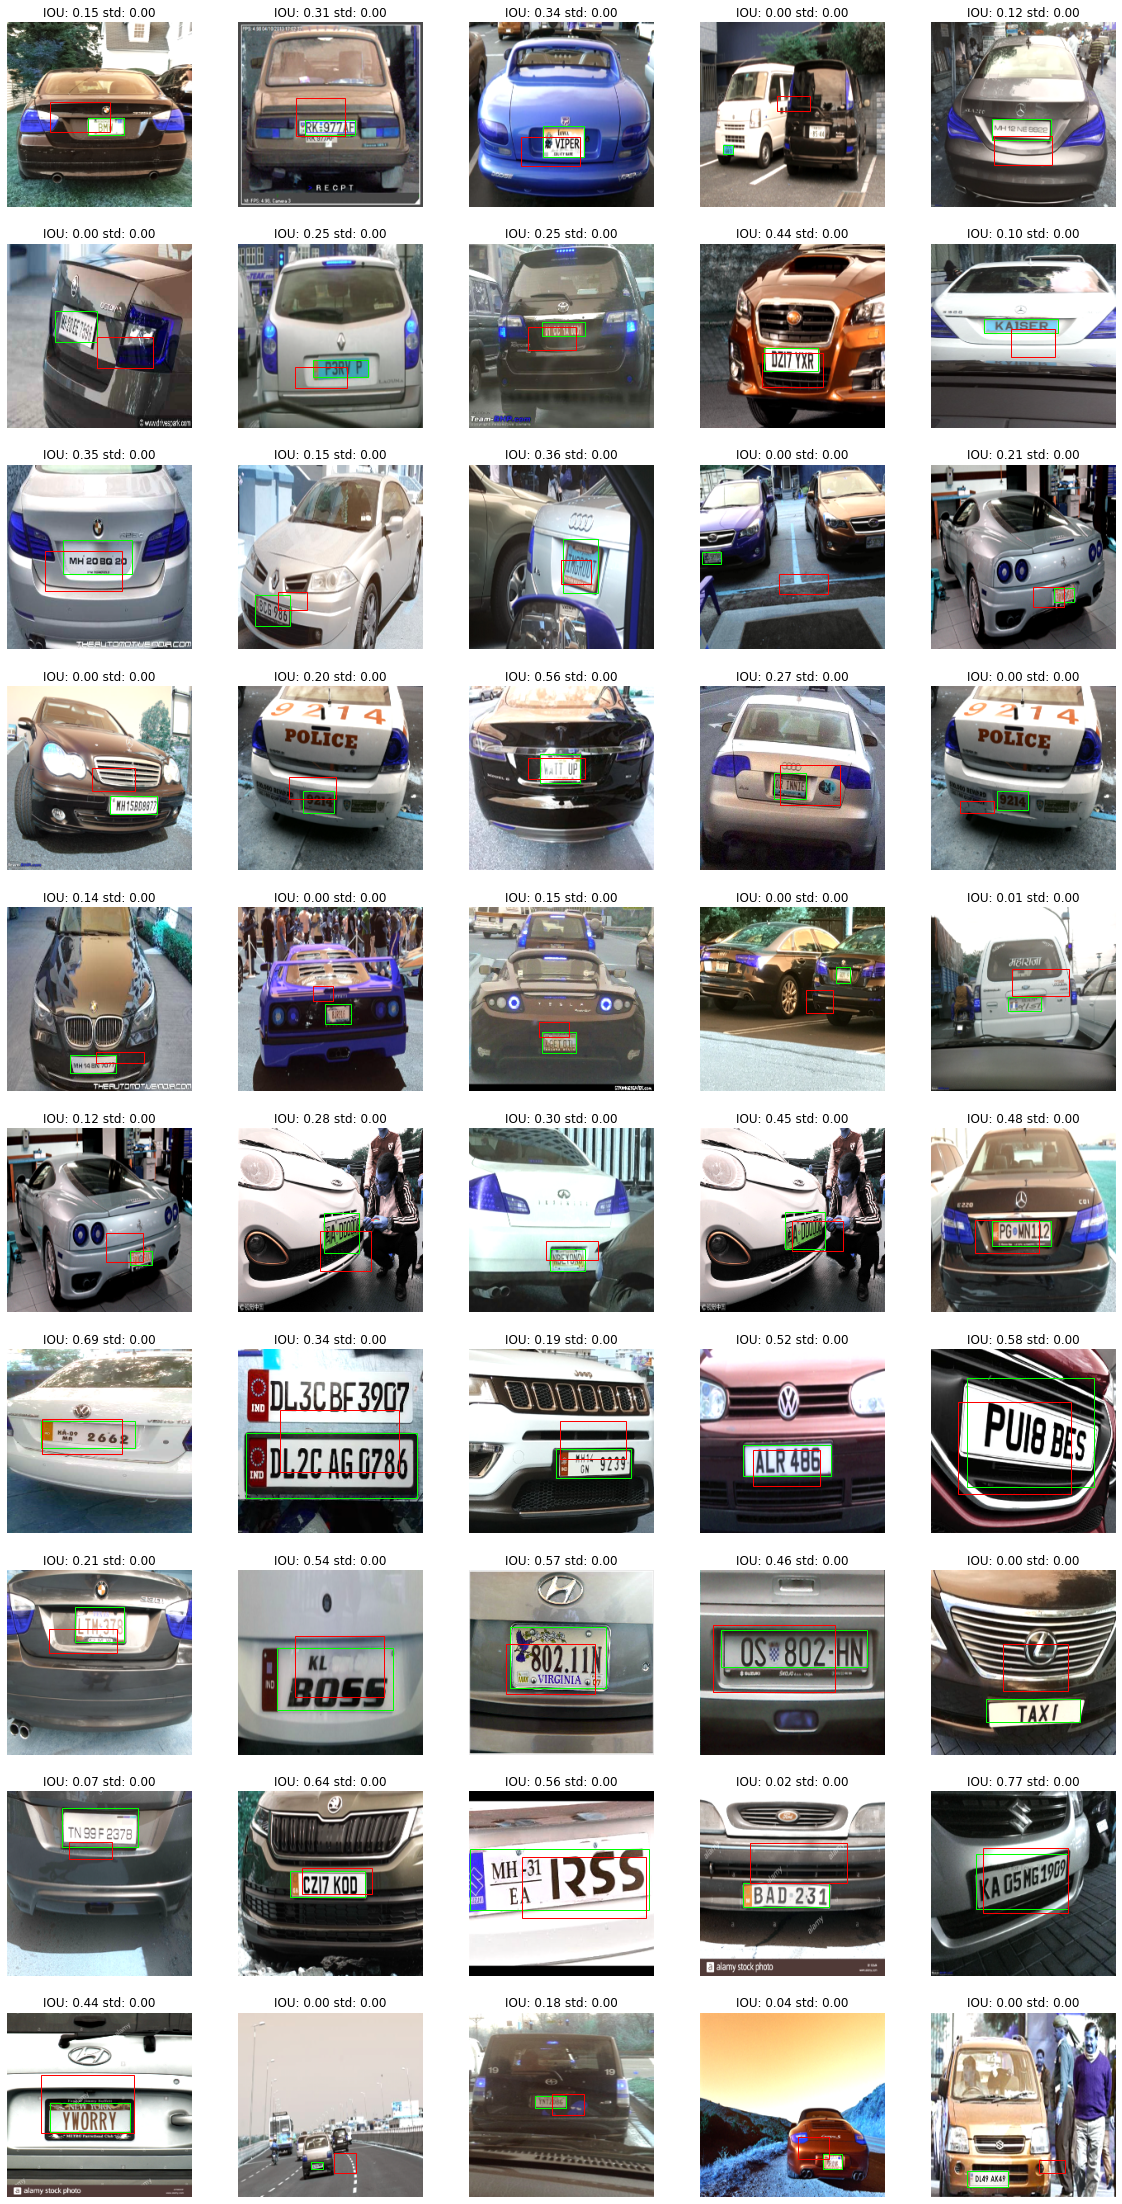

In [48]:
wandb.init(project="clustered-data-with-probability",
           config={
               "batch_size": 32,
               "learning_rate": 0.01,
               "dataset": "clustered-data-with-probability",
           })

model_prob = create_prob_model()

model_prob, y_pred_prob, map_prob = train(model_prob,
                                          X_train, y_train,
                                          X_val, y_val,
                                          X_test, y_test, 100, 32)


## Train with a noisy cluster

You can train with uniform or normal noise.

Run with some noise. The parameter scale defines the amount of noise.

In [340]:
def train_on_noise(scale, noise_type='normal', noise_clst_id=1,
                            X_train_d=X_train_d, y_train_d=y_train_d):

  wandb.init(project="norm-noise",
            config={
                "batch_size": 32,
                "learning_rate": 0.01,
                "dataset": "one-noisy-cluster-data-probability",
            })

  y_train_d_noise = deepcopy(y_train_d)
  y_noise = y_train_d_noise[noise_clst_id]

  y_noise = noise_annotation(y_noise*IMAGE_SIZE, scale, noise_type)
  y_noise = y_noise/IMAGE_SIZE
  y_train_d_noise[noise_clst_id] = np.array(y_noise)

  X_train = merge_clusters(y_train_d)
  y_train_noise = merge_clusters(y_train_d_noise)

  model_noise = create_prob_model()
  model_noise, y_preds, m_ap = run_experiment(model_noise,
                                        X_train, y_train_noise,
                                        X_val, y_val,
                                        X_test, y_test, 100, 32)

  # return y_train_d_noise too for later visualization
  return model_noise, y_preds, m_ap, y_train_d_noise

# plot_images(X_train_d[noise_clst_id], y_train_d_noise_norm[noise_clst_id])
# By default, use 5 as the noise scale. In other words 5 pixel values of IMAGE_SIZE
# or 0.02% of noise.

In [341]:
model_noise_norm, y_pred_noise_norm, map_noise_norm, y_train_d_noise_norm = train_on_noise(5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_33 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_101 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_flipout_33 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

In [342]:
model_noise_uni, y_pred_noise_uni, map_noise_uni, y_train_d_noise_uni = train_on_noise(5, noise_type='uniform')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_34 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_102 (Dense)            (None, 128)               3211392   
_________________________________________________________________
dense_103 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_104 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_flipout_34 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

## Train on only one cluster

In [ ]:
clst_id = 1

wandb.init(project="one-cluster-data-probability",
           config={
               "batch_size": 32,
               "learning_rate": 0.01,
               "dataset": "one-cluster-data-probability",
           })

model_prob_one_cluster = create_prob_model()
model_prob_one_cluster, y_pred_prob_one_cluster, map_prob_one_cluster = train(model_prob_one_cluster,
                                                   X_train_d[clst_id], y_train_d[clst_id],
                                                   X_val_d[clst_id], y_val_d[clst_id],
                                                   X_test_d[clst_id], y_test_d[clst_id], 100, 32)


## Train on only two clusters

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

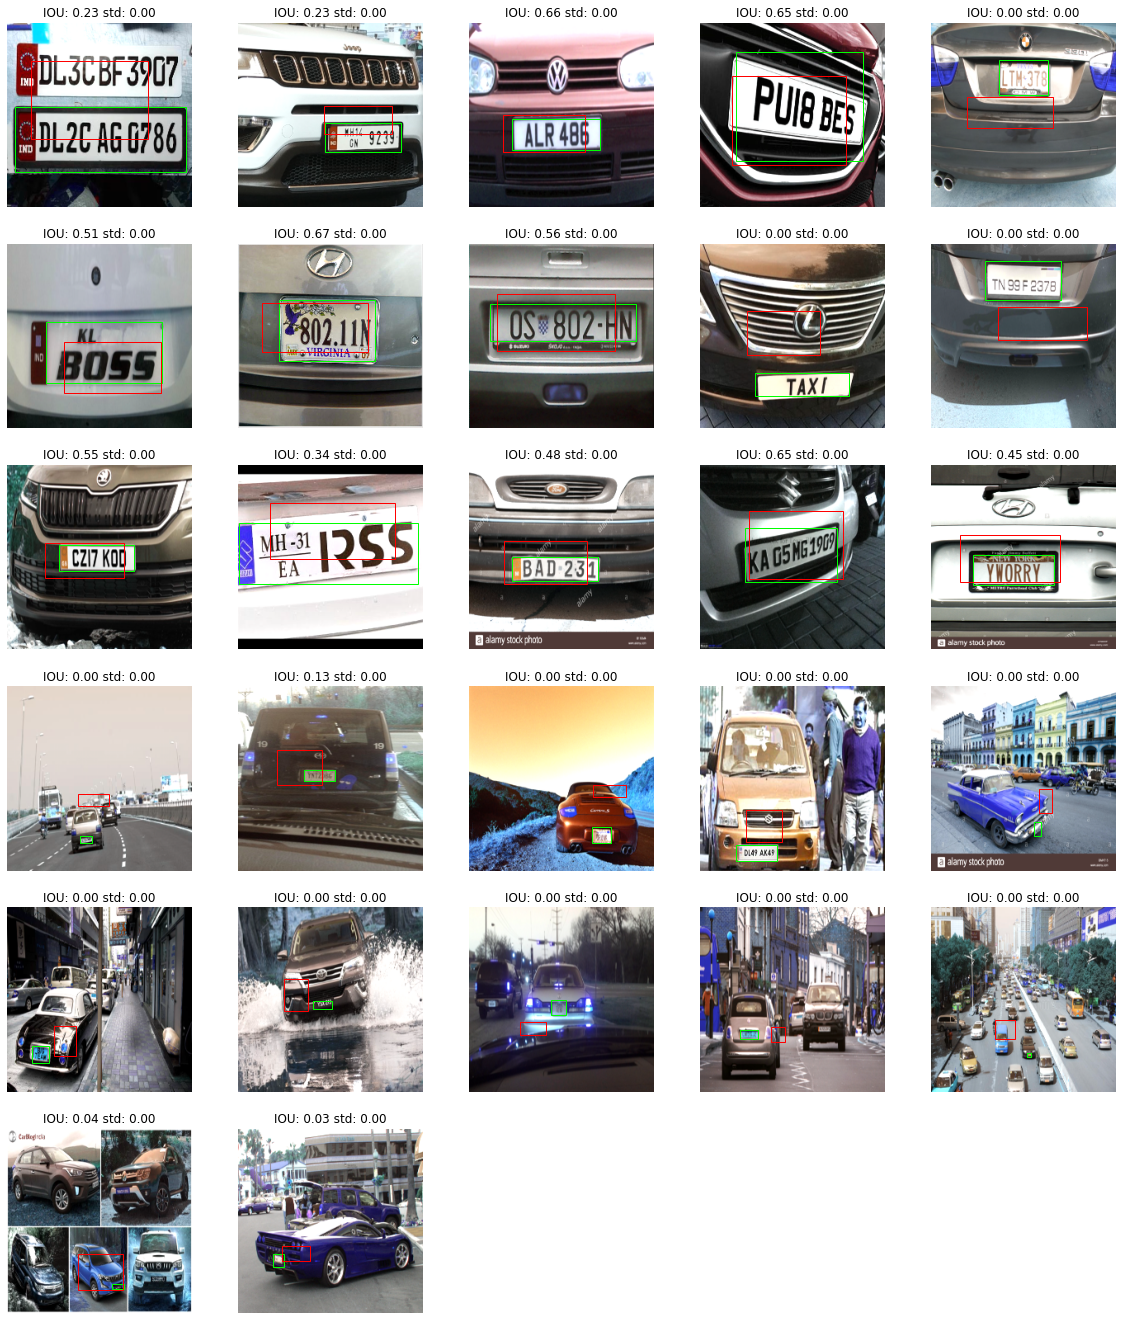

In [55]:
clst_id = 1

wandb.init(project="two-clusters-probability",
           config={
               "batch_size": 32,
               "learning_rate": 0.01,
               "dataset": "one-clusters-probability",
           })

X_train_2c = np.vstack((X_train_d[clst_id], X_train_d[clst_id + 1]))
y_train_2c = np.vstack((y_train_d[clst_id], y_train_d[clst_id + 1]))

X_val_2c = np.vstack((X_val_d[clst_id], X_val_d[clst_id + 1]))
y_val_2c = np.vstack((y_val_d[clst_id], y_val_d[clst_id + 1]))

X_test_2c = np.vstack((X_test_d[clst_id], X_test_d[clst_id + 1]))
y_test_2c = np.vstack((y_test_d[clst_id], y_test_d[clst_id + 1]))

model_two_clusters = create_prob_model()

model_two_clusters, y_pred_two_clusters, map_two_clusters = train(model_two_clusters,
                                                                  X_train_2c, y_train_2c,
                                                                  X_val_2c, y_val_2c,
                                                                  X_test_2c, y_test_2c, 100, 32)


# Predict and Analyze

After the models were trained, multiple predictions were made for the same data to get the probability distributions.

## Methods for prediction and analysis

In [69]:
def predict_on_cluster(model, X_test, y_test, is_plot_predictions=False, iterations=50):
  test_accuracy = 0
  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=1)
  y_preds = sample_predictions(model, X_test, iterations=iterations)

  # TODO:
  # Hack to fix erroneous predictions
  # y_preds_fixed = fix_predictions(y_preds)
  if is_plot_predictions:
    plot_predictions(X_test, y_test, y_preds)

  preds_avg = average_sample_preds(y_preds)
  rectified_y_test = np.array([to_rect(y*IMAGE_SIZE) for y in y_test])
  rectified_predictions = np.array([to_rect(y*IMAGE_SIZE) for y in preds_avg])

  m_ap = calculate_map(rectified_y_test*IMAGE_SIZE, rectified_predictions*IMAGE_SIZE)
  stds = np.mean(np.std(y_preds, axis=1), axis=1)

  return y_preds, m_ap, np.mean(stds, axis=0), test_accuracy

In [70]:
def predict_on_all_clusters(model, X, y, bins):
  stats = []
  for clst_id in bins:
    # y_preds, m_ap, accuracy, mstd = predict_on_cluster(model, X[clst_ids[clst_id]], y[clst_ids[clst_id]])
    y_preds, m_ap, std, accuracy = predict_on_cluster(model,
                                                      X[clst_id], y[clst_id],
                                                      is_plot_predictions=False)

    # stds = np.std(y_preds, axis=1)
    # mean_std = np.mean(stds, axis=1)
    # print(mean_std)
    # print("{}: mean std: {:0.2f}".format(cluster_id, np.mean(mean_std)))

    stats.append((m_ap['avg_prec'], std, accuracy))
    print("{} mAP: {:0.2f} std: {:0.2f} acc: {:0.2f}".format(clst_id, m_ap['avg_prec'],
                                                             std,
                                                             accuracy))
  return np.array(stats)

In [76]:
def predict_on_models(models, X, y, bins):
  stats = []
  for model in models:
    cluster_stats = []
    for clst_id in bins:
      # y_preds, m_ap, accuracy, mstd = predict_on_cluster(model, X[clst_ids[clst_id]], y[clst_ids[clst_id]])
      y_preds, m_ap, std, accuracy = predict_on_cluster(model, X[clst_id], y[clst_id])
      print("{} mAP: {:0.2f} std: {:0.2f} acc: {:0.2f}".format(clst_id,
                                                               m_ap['avg_prec'],
                                                               std,
                                                               accuracy))
      # cluster_stats[clst_id] = (m_ap['avg_prec'], std, accuracy)
      cluster_stats.append([m_ap['avg_prec'], std, accuracy])

    # stats[name] = cluster_stats
    stats.append(cluster_stats)
  # return np.array(stats)
  return np.array(stats)

In [72]:
def plot_stats(stats, types, titles):
  x_bar = np.arange(K)
  bar_width = .35

  fig = plt.figure(figsize=(20,40))

  for i, stat in zip(range(len(stats)), stats):
    ax = fig.add_subplot(10, 4, i+1)
    # plt.axis('off')

    for t in types:
      if "mAP" == t:
        rects1 = ax.bar(x_bar - bar_width/3, stat[:, 0], label="mAP")
      if "std" == t:
        rects2 = ax.bar(x_bar + bar_width/3, stat[:, 1], label="std")
      if "accuracy" == t:
        rects3 = ax.bar(x_bar + bar_width/3, stat[:, 2], label="accuracy")

    ax.set_xticks(x_bar)
    ax.set_xticklabels(x_bar)
    ax.set_title(titles[i])

    ax.legend()

  fig.tight_layout()

In [288]:
# plot line graph for comparing different noise level results
def plot_noise_stats(noise_levels, stats, column, title, clusters=bins):
  bins = len(noise_levels)
  fig = plt.figure(figsize=(20,40))
  ax = fig.add_subplot(10, 4, 1)

  for cluster_id in range(len(clusters)):
    p = ax.plot(noise_levels, stats[:bins, :, column][:, cluster_id], label=cluster_id)
  # p = ax.plot(noise_levels, stats[:bins, :, column][:, 0], color='green', label='0')

  ax.set_title(title)
  ax.legend()

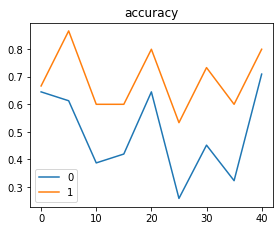

In [303]:
plot_noise_stats([0, 5, 10, 15, 20, 25, 30, 35, 40], stats_noise_uni_c1,  2, 'accuracy', clusters=[1, 2])

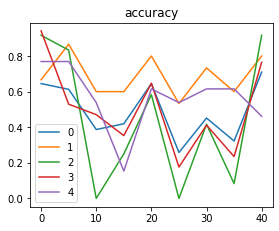

In [299]:
plot_noise_stats([0, 5, 10, 15, 20, 25, 30, 35, 40], stats_noise_uni_c1,  2, 'accuracy')

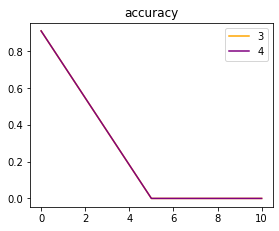

In [265]:
plot_noise_stats([0, 5, 10], stats_noise_uni_c1,  0, 'accuracy')

1/1 [==============================] - 0s 40ms/step - loss: 1.3489 - accuracy: 0.8000


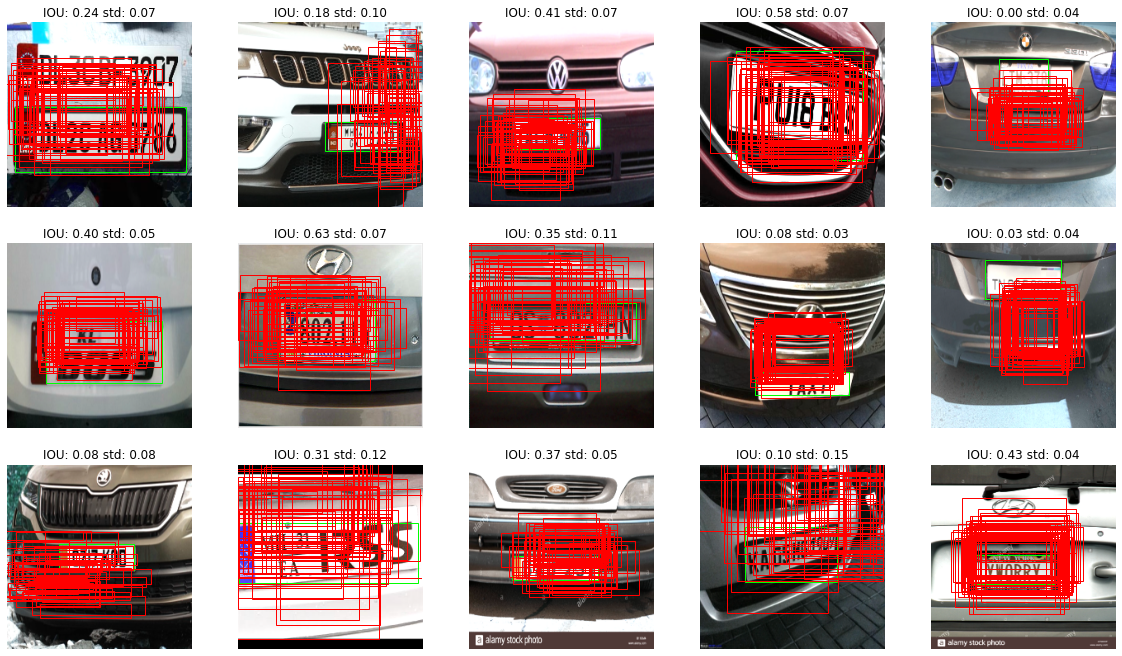

In [248]:
 _, _, c, d = predict_on_cluster(model_noise_uni80, X_test_d[1], y_test_d[1], is_plot_predictions=True)

1/1 [==============================] - 0s 44ms/step - loss: 1.3473 - accuracy: 0.7333


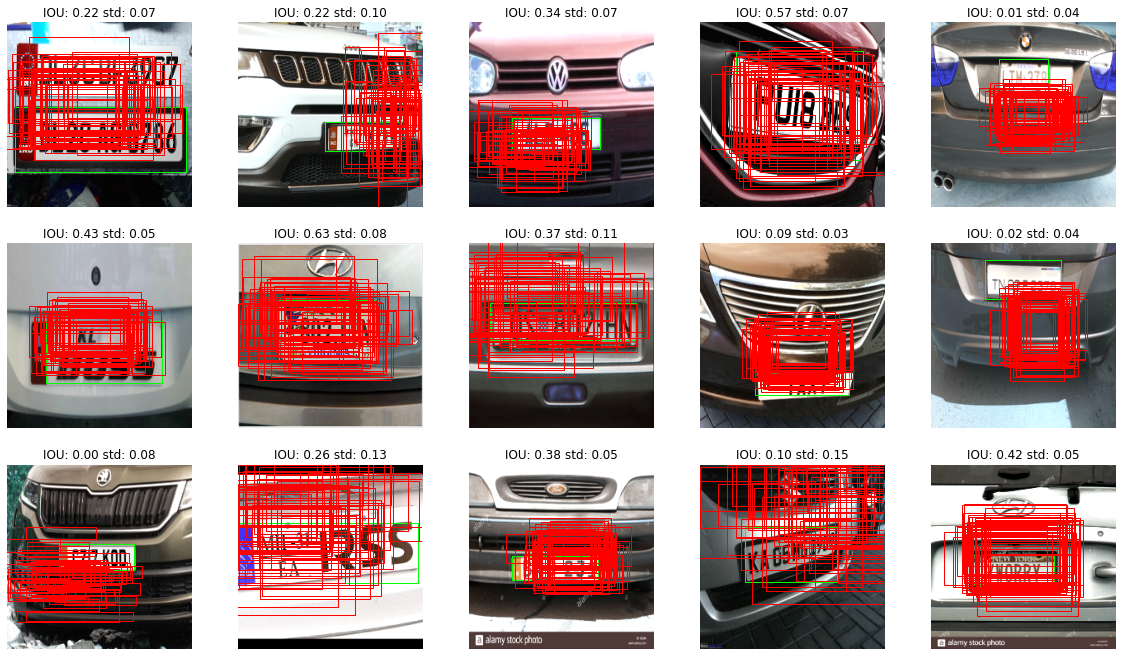

In [247]:
 _, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[1], y_test_d_noise_uni80[1], is_plot_predictions=True)

## Predict and Analyze
Compare the prediction of all models.

In [ ]:
model_noise_uni80_c0


In [98]:
stats_all = predict_on_models([model_prob, model_noise_uni, model_noise_norm, model_prob_one_cluster, model_two_clusters], X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 82ms/step - loss: 1.3313 - accuracy: 0.6774
0 mAP: 0.91 std: 0.05 acc: 0.68
1/1 [==============================] - 0s 56ms/step - loss: 1.3319 - accuracy: 0.6000
1 mAP: 0.91 std: 0.05 acc: 0.60
1/1 [==============================] - 0s 45ms/step - loss: 1.3326 - accuracy: 1.0000
2 mAP: 0.00 std: 0.06 acc: 1.00
1/1 [==============================] - 0s 55ms/step - loss: 1.3257 - accuracy: 0.8824
3 mAP: 0.91 std: 0.05 acc: 0.88
1/1 [==============================] - 0s 46ms/step - loss: 1.3415 - accuracy: 0.5385
4 mAP: 0.91 std: 0.06 acc: 0.54
1/1 [==============================] - 1s 628ms/step - loss: 1.3203 - accuracy: 0.6129
0 mAP: 0.91 std: 0.05 acc: 0.61
1/1 [==============================] - 0s 58ms/step - loss: 1.3249 - accuracy: 0.5333
1 mAP: 0.91 std: 0.05 acc: 0.53
1/1 [==============================] - 0s 58ms/step - loss: 1.3215 - accuracy: 0.8333
2 mAP: 0.00 std: 0.07 acc: 0.83
1/1 [==============================] - 0s 49ms/step - l

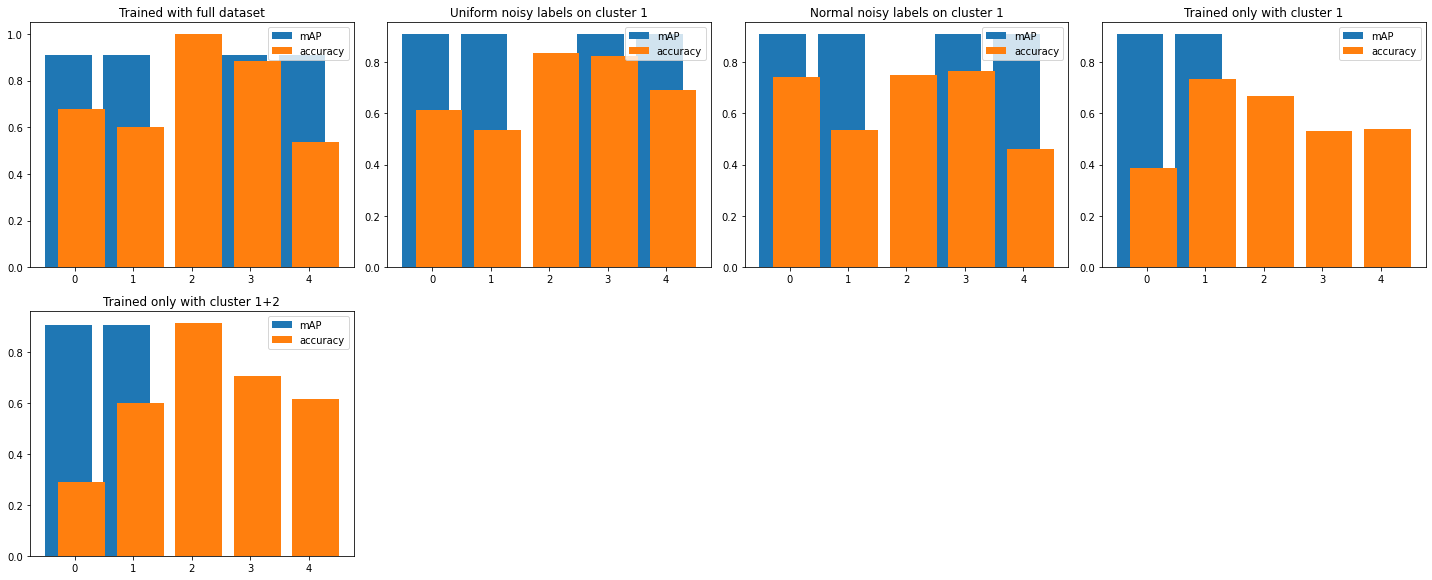

In [99]:
plot_stats(stats_all, ["mAP", "accuracy"], ["Trained with full dataset", "Uniform noisy labels on cluster 1", "Normal noisy labels on cluster 1", "Trained only with cluster 1", "Trained only with cluster 1+2"])

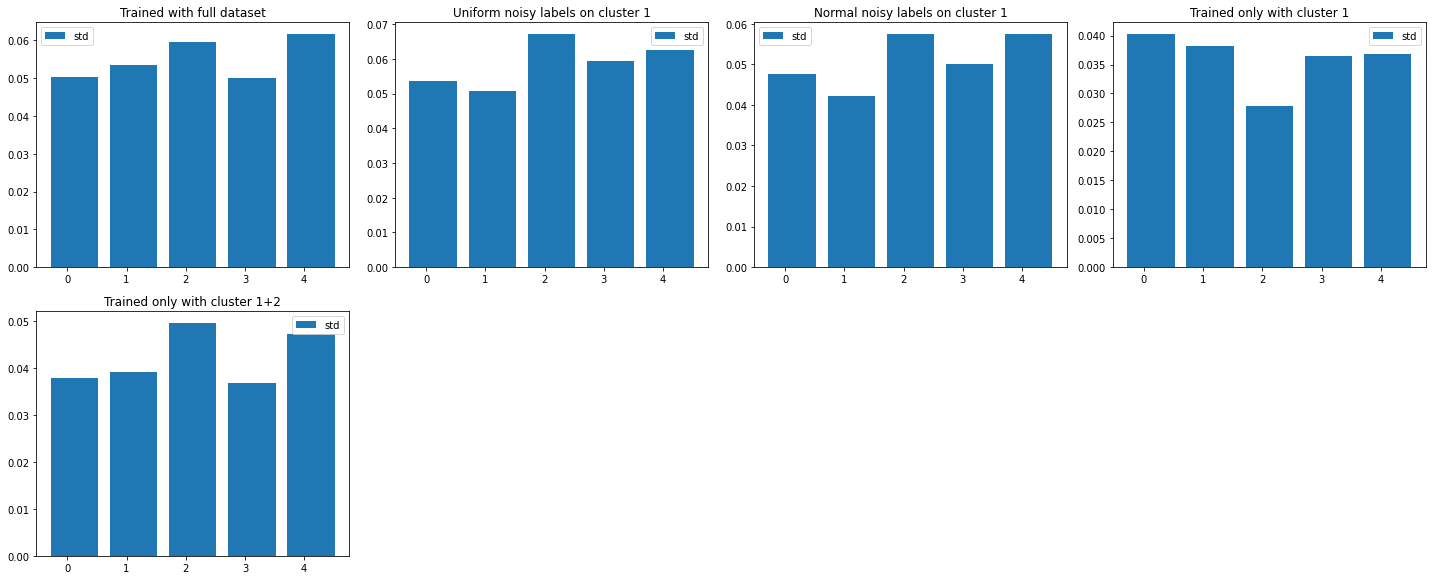

In [100]:
plot_stats(stats_all, ["std"], ["Trained with full dataset", "Uniform noisy labels on cluster 1", "Normal noisy labels on cluster 1", "Trained only with cluster 1", "Trained only with cluster 1+2"])

## Visualize predictions
Do some eyeballing on the predictions

In [325]:
_, _, _, _ = predict_on_cluster(model_noise_uni10, X_test_d[0], y_test_d[0], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni20, X_test_d[0], y_test_d[0], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni40, X_test_d[0], y_test_d[0], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[0], y_test_d[0], is_plot_predictions=False, iterations=200)

1/1 [==============================] - 0s 60ms/step - loss: 1.3355 - accuracy: 0.6774


In [321]:
_, _, _, _ = predict_on_cluster(model_noise_uni10, X_test_d[1], y_test_d[1], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni20, X_test_d[1], y_test_d[1], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni30_c1, X_test_d[1], y_test_d[1], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni40, X_test_d[1], y_test_d[1], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[1], y_test_d[1], is_plot_predictions=False, iterations=200)

1/1 [==============================] - 0s 44ms/step - loss: 1.3492 - accuracy: 0.8000


In [322]:
_, _, _, _ = predict_on_cluster(model_noise_uni10, X_test_d[2], y_test_d[2], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni20, X_test_d[2], y_test_d[2], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni40, X_test_d[2], y_test_d[2], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[2], y_test_d[2], is_plot_predictions=False, iterations=200)

1/1 [==============================] - 0s 35ms/step - loss: 1.3386 - accuracy: 0.6667


In [323]:
_, _, _, _ = predict_on_cluster(model_noise_uni10, X_test_d[3], y_test_d[3], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni20, X_test_d[3], y_test_d[3], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni40, X_test_d[3], y_test_d[3], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[3], y_test_d[3], is_plot_predictions=False, iterations=200)

1/1 [==============================] - 0s 49ms/step - loss: 1.3315 - accuracy: 0.8235


In [324]:
_, _, _, _ = predict_on_cluster(model_noise_uni10, X_test_d[4], y_test_d[4], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni20, X_test_d[4], y_test_d[4], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni40, X_test_d[4], y_test_d[4], is_plot_predictions=False, iterations=200)
_, _, _, _ = predict_on_cluster(model_noise_uni80, X_test_d[4], y_test_d[4], is_plot_predictions=False, iterations=200)

1/1 [==============================] - 0s 36ms/step - loss: 1.3440 - accuracy: 0.6923


## Experiment on the noise amount
Do some experiments by varying the noise amount.

In [ ]:
y_train_d_c0 = {0: y_train_d[0]}

model_noise_uni10_c0, _, _, y_train_d_noise_uni10_c0 = \
  train_on_noise(10, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[0], y_train_d=y_train_d_c0)

In [ ]:
model_noise_uni20_c0, _, _, y_train_d_noise_uni20_c0 = \
  train_on_noise(20, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[0], y_train_d=y_train_d_c0)

In [ ]:
model_noise_uni40_c0, _, _, y_train_d_noise_uni40_c0 = \
  train_on_noise(40, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[0], y_train_d=y_train_d_c0)

In [ ]:
model_noise_uni80_c0, _, _, y_train_d_noise_uni80_c0 = \
  train_on_noise(80, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[0], y_train_d=y_train_d_c0)

In [343]:
y_train_d_c1 = {0: y_train_d[1]}

# model_noise_uni5_c1, _, _, y_train_d_noise_uni5_c1 = \
#   run_experiment_on_noise(5, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)
model_noise_uni10_c1, _, _, y_train_d_noise_uni10_c1 = \
  train_on_noise(10, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)
model_noise_uni15_c1, _, _, y_train_d_noise_uni15_c1 = \
  train_on_noise(15, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)
model_noise_uni20_c1, _, _, y_train_d_noise_uni20_c1 = \
  train_on_noise(20, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)



wandb: ERROR Control-C detected -- Run data was not synced


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_35 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)               3211392   
_________________________________________________________________
dense_106 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_107 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_flipout_35 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_36 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_108 (Dense)            (None, 128)               3211392   
_________________________________________________________________
dense_109 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_110 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_flipout_36 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_37 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_111 (Dense)            (None, 128)               3211392   
_________________________________________________________________
dense_112 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_113 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_flipout_37 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

In [ ]:
model_noise_uni25_c1, _, _, y_train_d_noise_uni25_c1 = \
  train_on_noise(25, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)

model_noise_uni30_c1, _, _, y_train_d_noise_uni30_c1 = \
  train_on_noise(25, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)

model_noise_uni35_c1, _, _, y_train_d_noise_uni35_c1 = \
  train_on_noise(25, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)

model_noise_uni40_c1, _, _, y_train_d_noise_uni40_c1 = \
  train_on_noise(25, noise_type='uniform', noise_clst_id=0, X_train=X_train_d[1], y_train_d=y_train_d_c1)


In [ ]:
model_noise_uni5, _, _, y_train_d_noise_uni5 = train_on_noise(5, noise_type='uniform')
model_noise_uni10, _, _, y_train_d_noise_uni10 = train_on_noise(10, noise_type='uniform')
model_noise_uni15, _, _, y_train_d_noise_uni15 = train_on_noise(15, noise_type='uniform')
model_noise_uni20, _, _, y_train_d_noise_uni20 = train_on_noise(20, noise_type='uniform')

In [ ]:
model_noise_norm5, _, _, y_train_d_noise_norm5 = train_on_noise(5)
model_noise_norm10, _, _, y_train_d_noise_norm10 = train_on_noise(10)
model_noise_norm15, _, _, y_train_d_noise_norm15 = train_on_noise(15)
model_noise_norm20, _, _, y_train_d_noise_norm20 = train_on_noise(20)

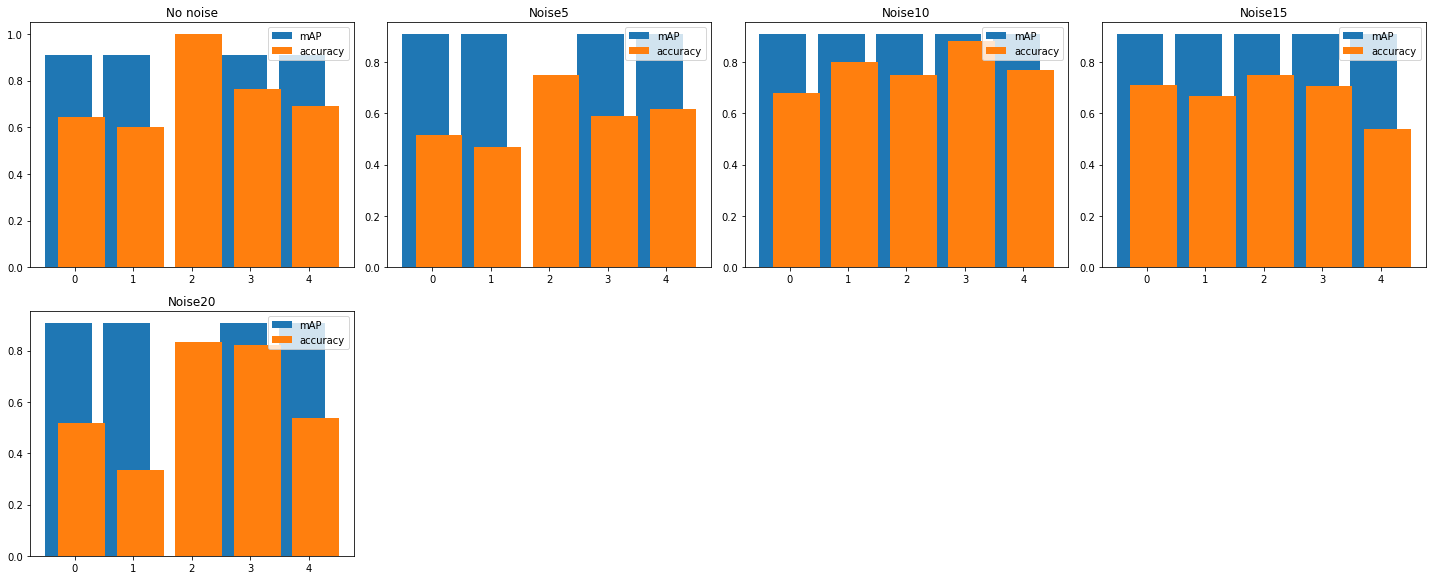

In [112]:
plot_stats(stats_noise_uni, ["mAP", "accuracy"], ["No noise", "Noise5", "Noise10", "Noise15", "Noise20"])

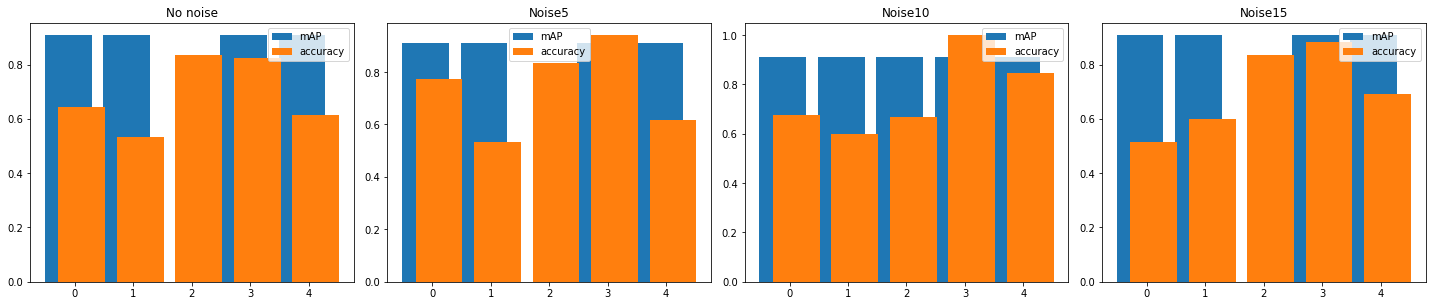

In [113]:
plot_stats(stats_noise_norm, ["mAP", "accuracy"], ["No noise", "Noise5", "Noise10", "Noise15", "Noise20"])

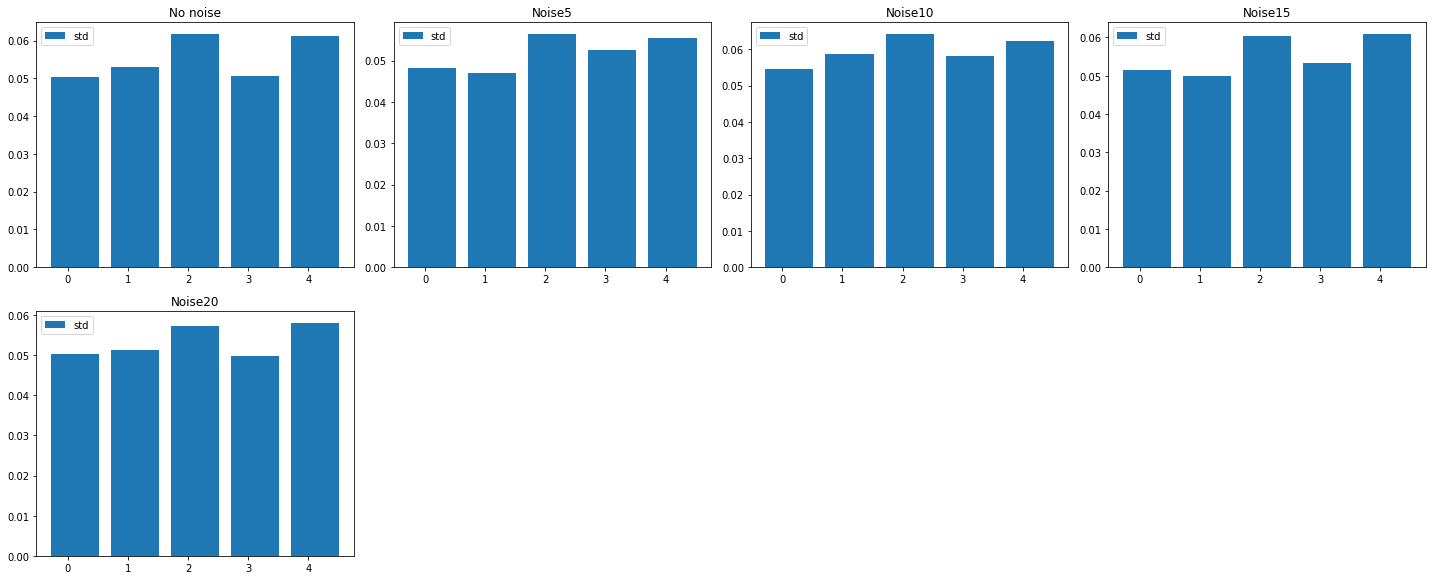

In [114]:
plot_stats(stats_noise_uni, ["std"], ["No noise", "Noise5", "Noise10", "Noise15", "Noise20"])

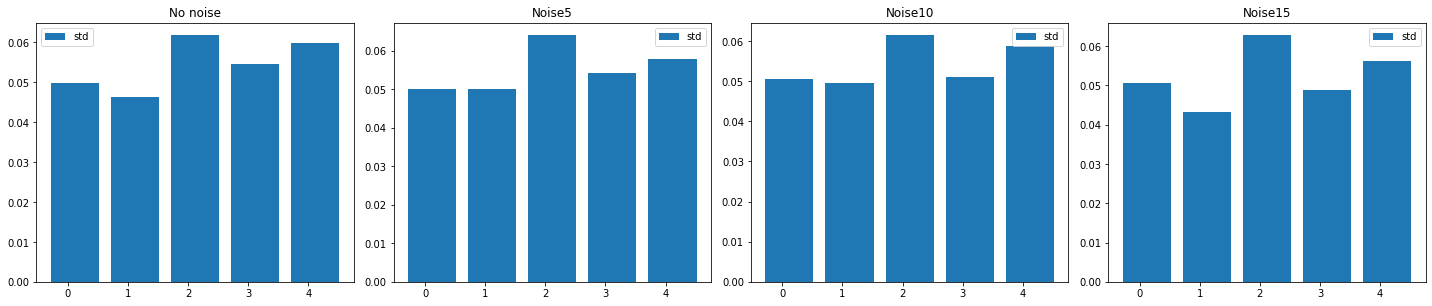

In [123]:
plot_stats(stats_noise_norm, ["std"], ["No noise", "Noise5", "Noise10", "Noise15", "Noise20"])

In [154]:
stats_noise_uni_c1 = \
  predict_on_models([model_prob, model_noise_uni5_c1, model_noise_uni10_c1, model_noise_uni15_c1, model_noise_uni20_c1],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 73ms/step - loss: 1.3324 - accuracy: 0.6129
0 mAP: 0.91 std: 0.05 acc: 0.61
1/1 [==============================] - 0s 58ms/step - loss: 1.3347 - accuracy: 0.5333
1 mAP: 0.91 std: 0.05 acc: 0.53
1/1 [==============================] - 0s 57ms/step - loss: 1.3349 - accuracy: 0.8333
2 mAP: 0.00 std: 0.06 acc: 0.83
1/1 [==============================] - 0s 69ms/step - loss: 1.3275 - accuracy: 0.8235
3 mAP: 0.91 std: 0.05 acc: 0.82
1/1 [==============================] - 0s 47ms/step - loss: 1.3381 - accuracy: 0.6154
4 mAP: 0.91 std: 0.06 acc: 0.62
1/1 [==============================] - 1s 552ms/step - loss: 1.9639 - accuracy: 0.4839
0 mAP: 0.91 std: 0.04 acc: 0.48
1/1 [==============================] - 0s 42ms/step - loss: 1.9538 - accuracy: 0.5333
1 mAP: 0.91 std: 0.03 acc: 0.53
1/1 [==============================] - 0s 39ms/step - loss: 2.0074 - accuracy: 0.7500
2 mAP: 0.00 std: 0.03 acc: 0.75
1/1 [==============================] - 0s 59ms/step - l

In [168]:
stats_noise_uni_c1 = \
  predict_on_models([model_prob,
                     model_noise_uni5_c1, model_noise_uni10_c1, model_noise_uni15_c1, model_noise_uni20_c1,
                     model_noise_uni25_c1, model_noise_uni30_c1, model_noise_uni35_c1, model_noise_uni40_c1
                     ],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 94ms/step - loss: 1.3333 - accuracy: 0.6452
0 mAP: 0.91 std: 0.05 acc: 0.65
1/1 [==============================] - 0s 49ms/step - loss: 1.3334 - accuracy: 0.6667
1 mAP: 0.91 std: 0.05 acc: 0.67
1/1 [==============================] - 0s 42ms/step - loss: 1.3296 - accuracy: 0.9167
2 mAP: 0.00 std: 0.06 acc: 0.92
1/1 [==============================] - 0s 70ms/step - loss: 1.3261 - accuracy: 0.9412
3 mAP: 0.91 std: 0.05 acc: 0.94
1/1 [==============================] - 0s 57ms/step - loss: 1.3357 - accuracy: 0.7692
4 mAP: 0.91 std: 0.06 acc: 0.77
1/1 [==============================] - 0s 88ms/step - loss: 1.9638 - accuracy: 0.6129
0 mAP: 0.91 std: 0.03 acc: 0.61
1/1 [==============================] - 0s 59ms/step - loss: 1.9557 - accuracy: 0.8667
1 mAP: 0.91 std: 0.03 acc: 0.87
1/1 [==============================] - 0s 55ms/step - loss: 2.0075 - accuracy: 0.8333
2 mAP: 0.00 std: 0.03 acc: 0.83
1/1 [==============================] - 0s 56ms/step - lo

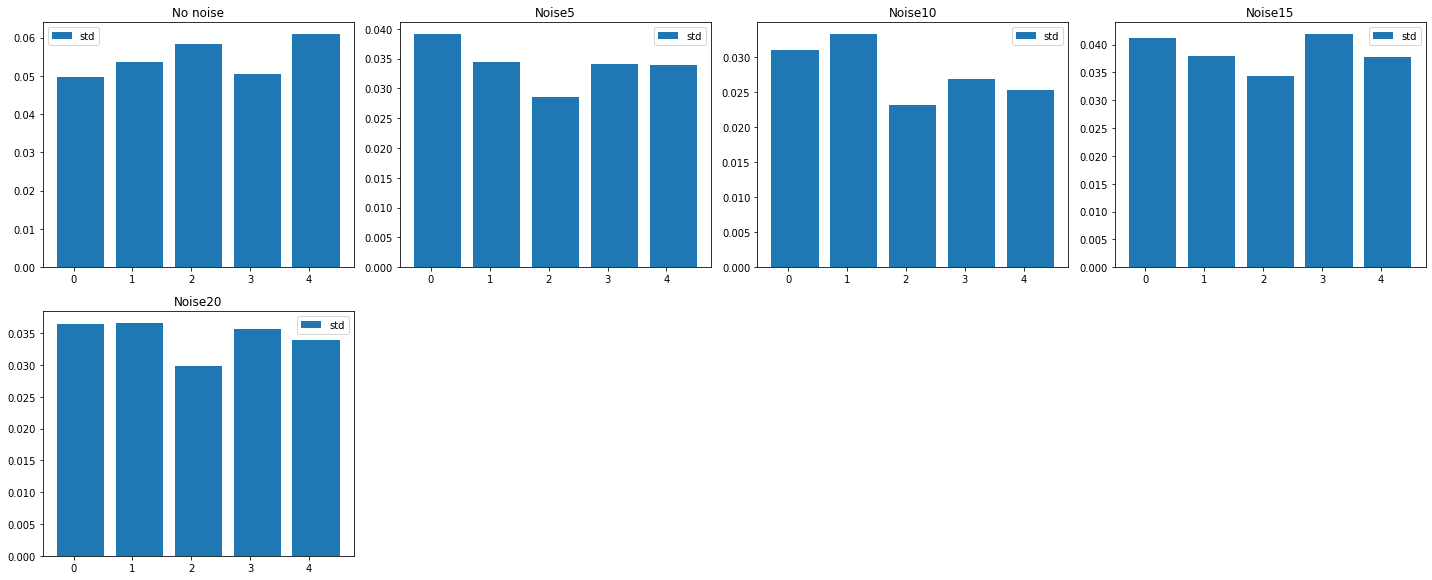

In [155]:
plot_stats(stats_noise_uni_c1, ["std"], ["No noise", "Noise5", "Noise10", "Noise15", "Noise20"])

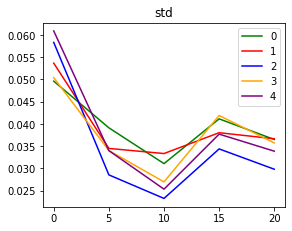

In [157]:
plot_noise_stats([0, 5, 10, 15, 20], stats_noise_uni_c1, 1, 'std')

In [127]:
stats_noise_uni = \
 predict_on_models([model_prob, model_noise_uni5, model_noise_uni10, model_noise_uni15, model_noise_uni20],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 56ms/step - loss: 1.3317 - accuracy: 0.7097
0 mAP: 0.91 std: 0.05 acc: 0.71
1/1 [==============================] - 0s 37ms/step - loss: 1.3390 - accuracy: 0.2667
1 mAP: 0.91 std: 0.05 acc: 0.27
1/1 [==============================] - 0s 34ms/step - loss: 1.3353 - accuracy: 0.8333
2 mAP: 0.00 std: 0.06 acc: 0.83
1/1 [==============================] - 0s 43ms/step - loss: 1.3255 - accuracy: 0.6471
3 mAP: 0.91 std: 0.05 acc: 0.65
1/1 [==============================] - 0s 35ms/step - loss: 1.3362 - accuracy: 0.7692
4 mAP: 0.91 std: 0.06 acc: 0.77
1/1 [==============================] - 0s 54ms/step - loss: 1.3227 - accuracy: 0.7419
0 mAP: 0.91 std: 0.05 acc: 0.74
1/1 [==============================] - 0s 37ms/step - loss: 1.3298 - accuracy: 0.4667
1 mAP: 0.91 std: 0.05 acc: 0.47
1/1 [==============================] - 0s 33ms/step - loss: 1.3267 - accuracy: 0.5833
2 mAP: 0.00 std: 0.06 acc: 0.58
1/1 [==============================] - 0s 43ms/step - lo

In [126]:
stats_noise_norm = \
 predict_on_models([model_prob, model_noise_norm5, model_noise_norm10, model_noise_norm15, model_noise_norm20],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 60ms/step - loss: 1.3316 - accuracy: 0.6774
0 mAP: 0.91 std: 0.05 acc: 0.68
1/1 [==============================] - 0s 35ms/step - loss: 1.3337 - accuracy: 0.7333
1 mAP: 0.91 std: 0.05 acc: 0.73
1/1 [==============================] - 0s 33ms/step - loss: 1.3308 - accuracy: 0.9167
2 mAP: 0.00 std: 0.06 acc: 0.92
1/1 [==============================] - 0s 43ms/step - loss: 1.3244 - accuracy: 0.8824
3 mAP: 0.91 std: 0.05 acc: 0.88
1/1 [==============================] - 0s 33ms/step - loss: 1.3423 - accuracy: 0.6154
4 mAP: 0.91 std: 0.06 acc: 0.62
1/1 [==============================] - 0s 57ms/step - loss: 1.3290 - accuracy: 0.7742
0 mAP: 0.91 std: 0.05 acc: 0.77
1/1 [==============================] - 0s 36ms/step - loss: 1.3317 - accuracy: 0.7333
1 mAP: 0.91 std: 0.04 acc: 0.73
1/1 [==============================] - 0s 34ms/step - loss: 1.3357 - accuracy: 0.8333
2 mAP: 0.00 std: 0.06 acc: 0.83
1/1 [==============================] - 0s 42ms/step - lo

In [134]:
model_noise_uni40, _, _, y_train_d_noise_uni40 = run_experiment_on_noise(40, noise_type='uniform')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_flipout_16 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

In [138]:
model_noise_uni80, _, _, y_train_d_noise_uni80 = run_experiment_on_noise(80, noise_type='uniform')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_18 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_flipout_18 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

In [139]:
stats_noise_uni80 = \
 predict_on_models([model_noise_uni80],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 1s 586ms/step - loss: 1.3364 - accuracy: 0.6452
0 mAP: 0.91 std: 0.05 acc: 0.65
1/1 [==============================] - 0s 53ms/step - loss: 1.3548 - accuracy: 0.4000
1 mAP: 0.91 std: 0.07 acc: 0.40
1/1 [==============================] - 0s 49ms/step - loss: 1.3441 - accuracy: 0.6667
2 mAP: 0.00 std: 0.06 acc: 0.67
1/1 [==============================] - 0s 68ms/step - loss: 1.3314 - accuracy: 0.7647
3 mAP: 0.91 std: 0.05 acc: 0.76
1/1 [==============================] - 0s 45ms/step - loss: 1.3468 - accuracy: 0.7692
4 mAP: 0.91 std: 0.06 acc: 0.77


In [ ]:
stats_noise_uni40 = \
 predict_on_models([model_noise_uni40],
                   X_test_d, y_test_d, bins)

In [135]:
model_noise_norm40, _, _, y_train_d_noise_norm40 = run_experiment_on_noise(40)

wandb: ERROR Control-C detected -- Run data was not synced


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_flipout_17 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

In [137]:
stats_noise_norm40 = \
 predict_on_models([model_noise_norm40],
                   X_test_d, y_test_d, bins)

1/1 [==============================] - 0s 64ms/step - loss: 1.3267 - accuracy: 0.6129
0 mAP: 0.91 std: 0.05 acc: 0.61
1/1 [==============================] - 0s 36ms/step - loss: 1.3359 - accuracy: 0.2667
1 mAP: 0.91 std: 0.06 acc: 0.27
1/1 [==============================] - 0s 35ms/step - loss: 1.3330 - accuracy: 0.9167
2 mAP: 0.00 std: 0.06 acc: 0.92
1/1 [==============================] - 0s 42ms/step - loss: 1.3217 - accuracy: 0.7647
3 mAP: 0.91 std: 0.05 acc: 0.76
1/1 [==============================] - 0s 36ms/step - loss: 1.3329 - accuracy: 0.7692
4 mAP: 0.91 std: 0.06 acc: 0.77


In [ ]:
stats_noise+

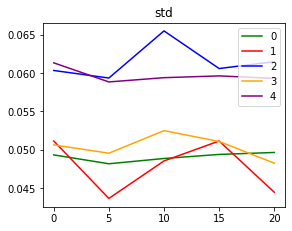

In [130]:
plot_noise_stats([0, 5, 10, 15, 20], stats_noise_norm, 1, 'std')

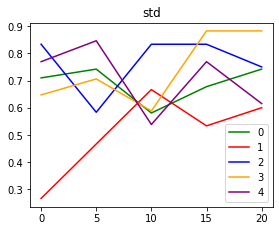

In [131]:
plot_noise_stats([0, 5, 10, 15, 20], stats_noise_uni, 2, 'accuracy')

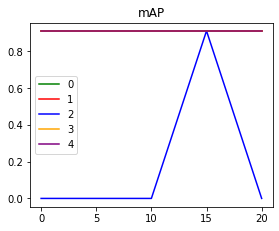

In [132]:
plot_noise_stats([0, 5, 10, 15, 20], stats_noise_uni, 0, 'mAP')

# Reference
- [TensorFlow Probability regression tutorial](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)